In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Neural Network implementation with Matrices #5: Parametrised Algorhytm

Here, we will implement an algorithm that can train a neural network of a flexible size in terms of the number of layers and neurons therein.

In this first example, the data and the labels will remain the same as in the previous examples:

In [2]:
data = np.array([[ 1.2, 0.7],
                 [-0.3,-0.5],
                 [ 3.0, 0.1],
                 [-0.1,-1.0],
                 [-0.0, 1.1],
                 [ 2.1,-1.3],
                 [ 3.1,-1.8],
                 [ 1.1,-0.1],
                 [ 1.5,-2.2],
                 [ 4.0,-1.0]])

In [3]:
labels = np.array([  1,
                    -1,
                     1,
                    -1,
                    -1,
                     1,
                    -1,
                     1,
                    -1,
                    -1])

## Transformation of the data in the matrix format

From now on, we will expect our data to be already transformed in the proper style, so we will do it right from the beginning, and update the plotting functions to accomodate for this,

In [4]:
data = np.array([d.reshape(1,2).T for d in data])
data

array([[[ 1.2],
        [ 0.7]],

       [[-0.3],
        [-0.5]],

       [[ 3. ],
        [ 0.1]],

       [[-0.1],
        [-1. ]],

       [[-0. ],
        [ 1.1]],

       [[ 2.1],
        [-1.3]],

       [[ 3.1],
        [-1.8]],

       [[ 1.1],
        [-0.1]],

       [[ 1.5],
        [-2.2]],

       [[ 4. ],
        [-1. ]]])

In [5]:
labels = np.array([np.array([1,0]).reshape(1,2).T if l==-1 
          else np.array([0,1]).reshape(1,2).T if l==1 
          else None 
          for l in labels])
labels

array([[[0],
        [1]],

       [[1],
        [0]],

       [[0],
        [1]],

       [[1],
        [0]],

       [[1],
        [0]],

       [[0],
        [1]],

       [[1],
        [0]],

       [[0],
        [1]],

       [[1],
        [0]],

       [[1],
        [0]]])

In [6]:
def plot_data(data, labels):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    labels = [np.argmax(l) for l in labels]
    ax.scatter(data[:,0].T[0], data[:,1].T[0], c=labels, s=50,  cmap=plt.cm.bwr,zorder=50)
    nudge = 0.08
    for i, (X,Y) in enumerate(data):
        ax.annotate(f'{i}',(X+nudge,Y+nudge))
    ax.set_aspect('equal', 'datalim')
    plt.show()

def create_meshgrid(data):
    h = 0.02
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return (xx,yy,np.ones(xx.shape))

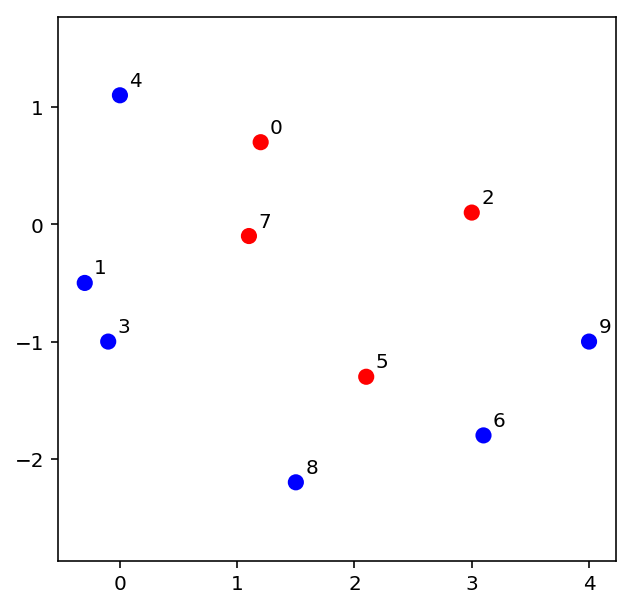

In [7]:
plot_data(data, labels)

## The flexible neural network algorithm

In [8]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def plot_neural_simple(grid, weights, biases, data, labels, iteration, accuracy):
    nudge = 0.06
    xx,yy,Z = grid
    
    for i in range(xx.shape[0]): # row
        for j in range(yy.shape[1]): #column
                a = np.array([xx[i][j], yy[i][j]]).reshape(1,2).T # current activation
                # calculate all the weighted sums and activations
                for b, w in zip(biases, weights):
                    w_sum = np.dot(w, a)+b #current weighted sum
                    a = sigmoid(w_sum) # current activation is updated and then the loop goes to the next layer
                    score = 0
                    if (np.argmax(a)==0):
                        score =  -1
                    else:
                        score =  1
                    Z[i][j] = score
    
    labels = [np.argmax(l) for l in labels]
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.title(f'accuracy at the iteration {iteration}: {accuracy}')
    ax.contourf(xx, yy, Z, cmap=plt.cm.binary, alpha=0.1, zorder=15)
    ax.scatter(data[:, 0].T[0], data[:, 1].T[0], c=labels, s=50,  cmap=plt.cm.bwr,zorder=50)
    ax.set_aspect('equal')
    for i in range(data.shape[0]):
        d = data[i]
        ax.annotate(f'{i}',(d[0]+nudge,d[1]+nudge))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
    
def eval_accuracy_neural(weights, biases, data, labels):
    num_correct = 0;
    for dpoint, label in zip(data, labels):
        a = dpoint
        for b, w in zip(biases, weights):
            w_sum = np.dot(w, a)+b #current weighted sum
            a = sigmoid(w_sum) # current activation is updated and then the loop goes to the next layer
        sc = np.array((int(a[0]>0.5),int(a[1]>0.5)))
        if (sc[0]==label[0] and sc[1]==label[1]):
            num_correct += 1
    return round(num_correct / len(data), 4)

def backprop(x, y, weights, biases, num_layers):
    # storing derivatives for the current data point
    d_biases =  [np.zeros(b.shape) for b in biases]
    d_weights = [np.zeros(w.shape) for w in weights]
    
    a = x # current activation
    activations = [x] # here we store all the activations, layer by layer
    weighted_sums = [] # here we store all the weighted sums, layer by layer
    
    # calculate all the weighted sums and activations
    for b, w in zip(biases, weights):
        w_sum = np.dot(w, a)+b #current weighted sum
        weighted_sums.append(w_sum) 
        a = sigmoid(w_sum) # current activation is updated and then the loop goes to the next layer
        activations.append(a)
    
    # computing the cost for a single example
    cost = 0.5*sum((y - a)**2)[0]
        
    #backward pass
    # output layer
    d_w_sum = (activations[-1] - y) * (activations[-1] * (1 - activations[-1]))
    d_biases[-1] = d_w_sum
    d_weights[-1] = np.dot(d_w_sum, activations[-2].T)
        
    # other layers
    for i in range(2, num_layers):
        act = activations[-i]
        d_w_sum = np.dot(weights[-i+1].T, d_w_sum) * (act * (1 - act))
        d_biases[-i] = d_w_sum
        d_weights[-i] = np.dot(d_w_sum, activations[-i-1].T)
    return (d_biases, d_weights, cost)


def train_neural_network(sizes, data, labels, step_size, no_epochs, iter_info):
    
    grid = create_meshgrid(data) # used for visualisation
    num_layers = len(sizes)  # number of layers
    data_len = len(data) # number of data points
    
    # initialising random weights and biases 
    biases  = [np.random.randn(y, 1) for y in sizes[1:]]
    weights = [np.random.randn(x, y) for x, y in zip(sizes[1:], sizes[:-1])]
    
    for epoch in range(no_epochs):
        total_cost = 0 # total cost for all training examples
        # in avg_d_biases/weights we store the averaged partial derivatives
        avg_d_biases =  [np.zeros(b.shape) for b in biases]
        avg_d_weights = [np.zeros(w.shape) for w in weights]

        for x, y in zip(data, labels):
            d_biases, d_weights, cost = backprop(x, y, weights, biases, num_layers)
            # averaging the derivatives of weights and biases
            avg_d_biases  = [nb+dnb for nb, dnb in zip(avg_d_biases, d_biases)]
            avg_d_weights = [nw+dnw for nw, dnw in zip(avg_d_weights, d_weights)]
            total_cost += cost
            
        # updating the weights and biases
        weights = [w - (step_size/data_len * dw) 
               for w, dw in zip(weights, avg_d_weights)]
        biases =  [b - (step_size/data_len * db)
              for b, db in zip(biases, avg_d_biases)]
        
        if (epoch%iter_info==0):
            accuracy = eval_accuracy_neural(weights, biases, data, labels)
            plot_neural_simple(grid, weights, biases, data, labels, epoch, accuracy)
            print (f'total cost: {round(total_cost,4)}')
    return (weights, biases)

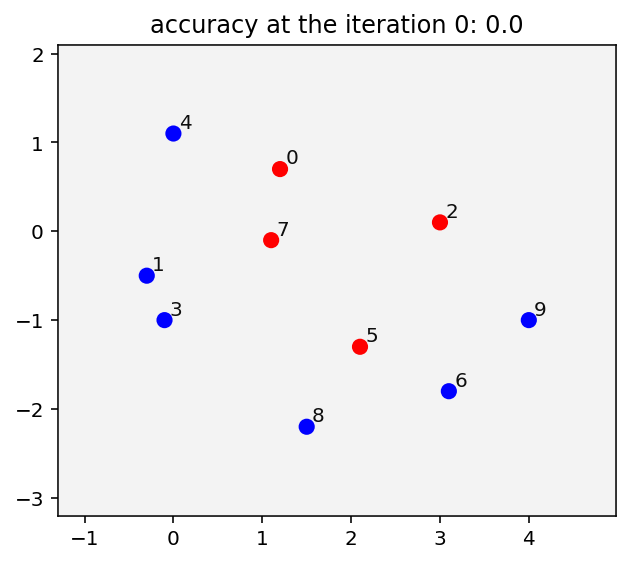

total cost: 2.7253


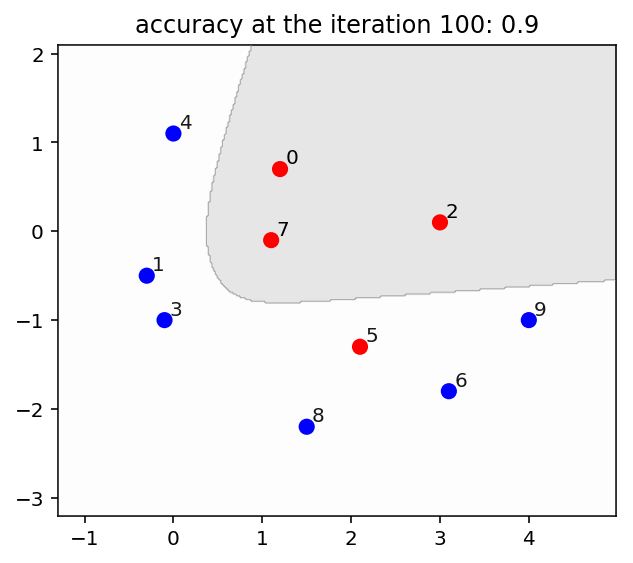

total cost: 0.8337


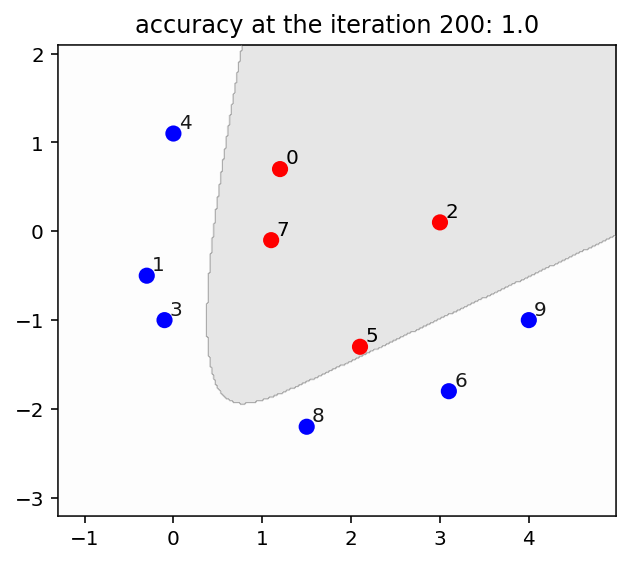

total cost: 0.3916


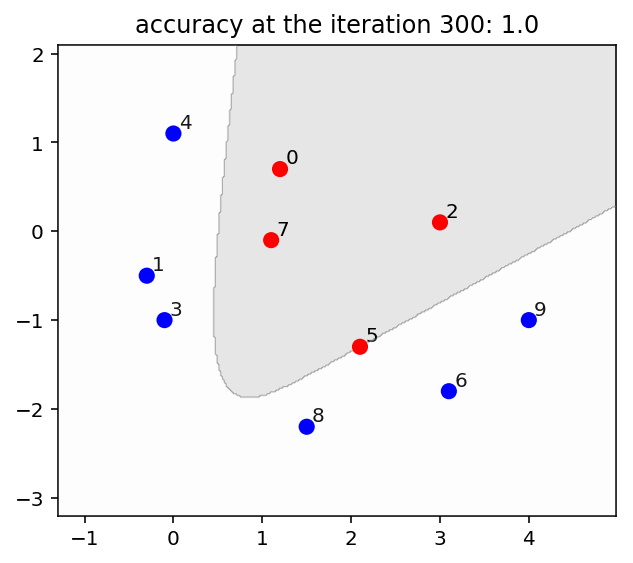

total cost: 0.228


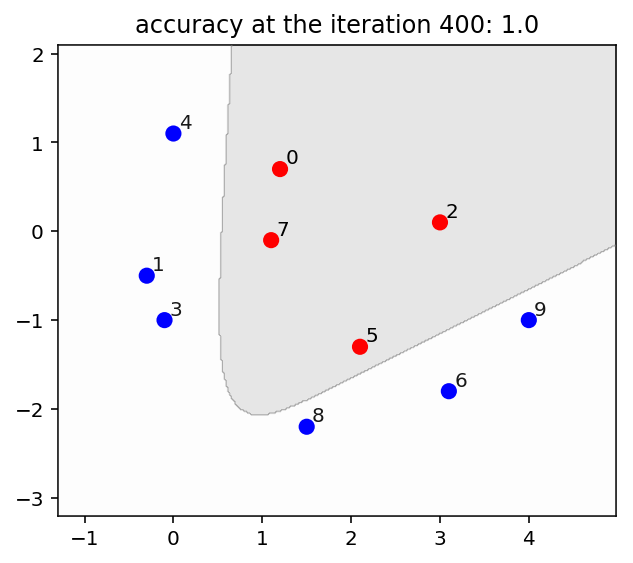

total cost: 0.1168


In [9]:
weights, biases = train_neural_network([2,3,2], data, labels, step_size=6, no_epochs=401, iter_info=100)